In [26]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from QRNN import QRNN

# --- Hyperparameters (match training) ---
N_QUBITS = 8
REPEAT_BLOCKS = 1
CONTEXT_LENGTH = 3
PREDICTION_HORIZON = 1
IN_DIM = 1
OUT_DIM = 2
SHOTS = 9000
BATCH_SIZE = 1

In [27]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# --- Load full Lorenz data ---
try:
    raw_data = np.load("train_data_lorenz_full.npy")
except FileNotFoundError:
    print("Error: 'train_data_lorenz_full.npy' not found.")
    raise

# Split into train/test
split_index = int(len(raw_data) * 0.7)
test_data = raw_data[split_index:]  # full test sequence

# Input = only the driving dimension (col 0)
# Labels = the prediction targets (col 1,2)
X_test = torch.tensor(test_data[:, 0], dtype=torch.float32).view(1, -1, 1).to(device)  # shape (1, seq_len, in_dim)
y_test = torch.tensor(test_data[:, 1:3], dtype=torch.float32).view(1, -1, OUT_DIM).to(device)


# --- Build context-windowed test sequence ---
inputs = []
labels = []
total_length = CONTEXT_LENGTH + PREDICTION_HORIZON

for i in range(len(test_data) - total_length + 1):
    # input = sliding window from first column
    window = test_data[i : i + CONTEXT_LENGTH, 0]
    inputs.append(window)

    # label = future target from columns 1:3
    label = test_data[i + CONTEXT_LENGTH + PREDICTION_HORIZON - 1, 1:3]
    labels.append(label)

inputs = inputs
labels = labels

X_test = torch.tensor(inputs, dtype=torch.float32).view(1, -1, CONTEXT_LENGTH * IN_DIM).to(device)
y_test = torch.tensor(labels, dtype=torch.float32).view(1, -1, OUT_DIM).to(device)

print(f"Test data shape: {X_test.shape}, Labels shape: {y_test.shape}")
#model.sequence_length = X_test.shape[1]

Using device: cpu
Test data shape: torch.Size([1, 2967, 3]), Labels shape: torch.Size([1, 2967, 2])


In [28]:


# --- Load pretrained model ---
checkpoint_path = "./checkpoints/lorenz_8_spsa_SIMPLE_1_1024_3_QRNN_600.pth"   # adjust to your checkpoint
model = QRNN(
    n_qubits=N_QUBITS,
    repeat_blocks=REPEAT_BLOCKS,
    in_dim=IN_DIM,
    out_dim=OUT_DIM,
    context_length=CONTEXT_LENGTH,
    sequence_length=X_test.shape[1],   # we’ll set dynamically
    batch_size=BATCH_SIZE,
    grad_method="finite-diff",
    shots=SHOTS
).to(device)

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model.eval()
print(f"✅ Loaded checkpoint from {checkpoint_path}")


Params per timestep: 39
✅ Loaded checkpoint from ./checkpoints/lorenz_8_spsa_SIMPLE_1_1024_3_QRNN_600.pth


In [29]:
#Print model weights
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")

input_layer.weight: tensor([[ 0.9973,  0.4981,  0.9725],
        [-0.0682,  0.3707,  0.7763],
        [ 1.3417,  0.8828,  0.5986],
        [ 0.8936,  1.0118,  1.4118],
        [-0.7776, -0.6820, -1.0503],
        [ 0.7518,  0.4413,  1.2301],
        [-0.9901, -0.4776, -0.4376],
        [-0.7775,  0.1479,  0.2739],
        [ 0.2267, -0.5214, -0.4409],
        [ 0.0746,  0.8105, -1.1384],
        [ 0.6018, -0.5201, -0.0963],
        [-1.0584,  0.7847, -0.9595],
        [-0.2208,  0.3976,  0.9995],
        [-0.3867,  0.5878, -0.9409],
        [-0.3968, -0.6083, -0.3353],
        [-0.9727,  0.0990, -0.7905],
        [ 0.6025, -0.2171,  0.3334],
        [-0.7462,  0.0776, -0.5576],
        [ 0.1462, -0.7356, -0.5933],
        [-0.7950, -0.1222,  0.7720],
        [ 0.5435,  0.8124, -0.4199],
        [-0.8939, -0.1064, -1.4657],
        [ 0.3685,  0.3430, -0.9078],
        [ 1.0522,  0.5359, -0.4774],
        [ 0.6025, -1.2796, -0.3640],
        [ 0.4561,  0.2991, -0.1016],
        [-0.2980, 

In [30]:
print("Input shape:", X_test.shape)
print("Target shape:", y_test.shape)

# --- Run model on full test sequence ---
with torch.no_grad():
    preds,_ = model(X_test)

preds = preds.cpu().numpy()   # (seq_len, out_dim)
y_true = y_test.cpu().numpy()[0]

print("Predictions shape:", preds.shape)
print("Targets shape:", y_true.shape)

# --- Plot results ---
timesteps = np.arange(len(y_true))

Input shape: torch.Size([1, 2967, 3])
Target shape: torch.Size([1, 2967, 2])
Predictions shape: (1, 2967, 2)
Targets shape: (2967, 2)


In [31]:
preds = preds[0]

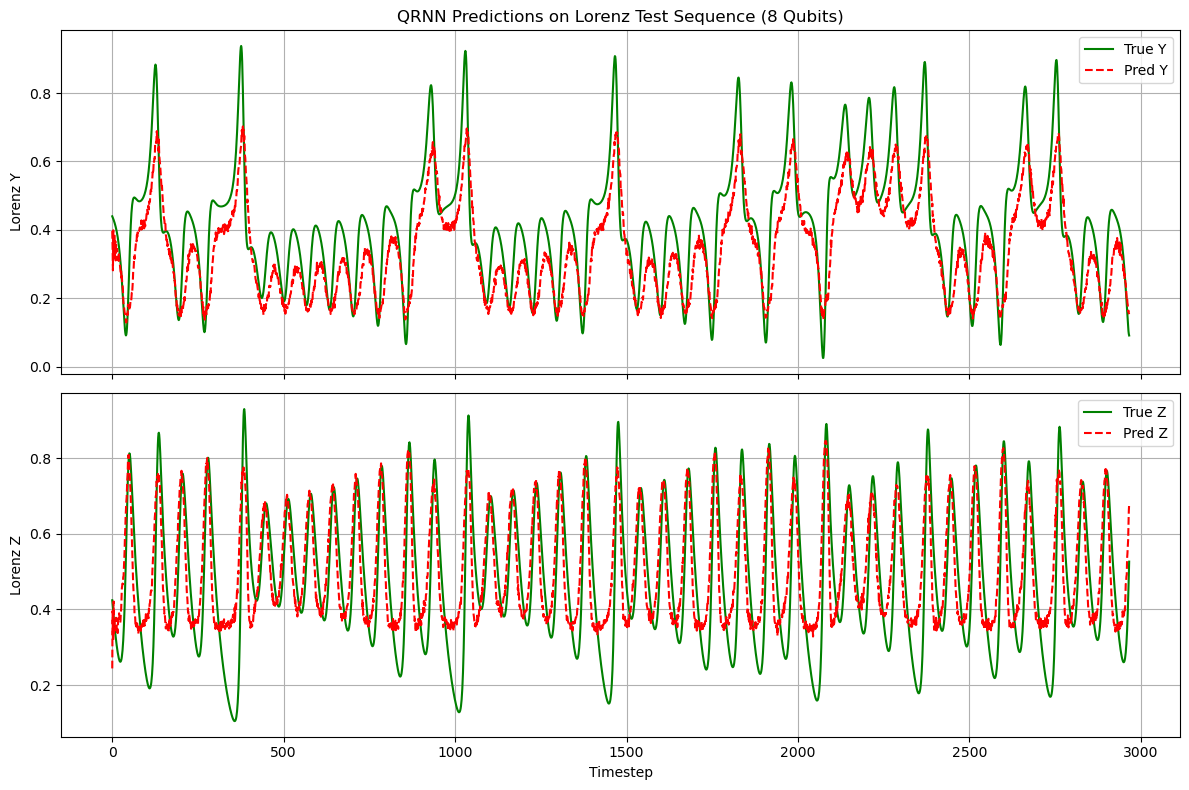

In [32]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- Dimension 0 ---
axes[0].plot(timesteps, y_true[:, 0], label="True Y", color="green")
axes[0].plot(timesteps, preds[:, 0], "--", label="Pred Y", color="red")
axes[0].set_ylabel("Lorenz Y")
axes[0].set_title("QRNN Predictions on Lorenz Test Sequence (8 Qubits)")
axes[0].legend()
axes[0].grid(True)

# --- Dimension 1 ---
axes[1].plot(timesteps, y_true[:, 1], label="True Z", color="green")
axes[1].plot(timesteps, preds[:, 1], "--", label="Pred Z", color="red")
axes[1].set_xlabel("Timestep")
axes[1].set_ylabel("Lorenz Z")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [33]:
#Compute RMSE
rmse_dim0 = np.sqrt(np.mean((y_true[:, 0] - preds[:, 0])**2))
rmse_dim1 = np.sqrt(np.mean((y_true[:, 1] - preds[:, 1])**2))
print(f"RMSE Dimension 0: {rmse_dim0:.6f}")
print(f"RMSE Dimension 1: {rmse_dim1:.6f}")
print(f"Average RMSE: {(rmse_dim0 + rmse_dim1) / 2:.6f}")


RMSE Dimension 0: 0.109848
RMSE Dimension 1: 0.120227
Average RMSE: 0.115037
